# `EmissionAbsorptionMismatchedModel` Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate the basic features of the `EmissionAbsorptionMismatchedModel` model. `EmissionAbsorptionMismatchedModel` models both 21cm emission and absorption observations allowing for a "filling factor" term to account for beam dilution effects in the emission spectra and an "absorption weight" term to account for a mismatch between emission beamsize and absorption beamsize (i.e., to account for clouds seen in emission that are not in the absorption beam).

In [2]:
# General imports
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

print("pymc version:", pm.__version__)

import bayes_spec

print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi

print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.1
caribou_hi version: 1.2.0+0.gcbda584.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `EmissionAbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"emission"` and `"absorption"`.

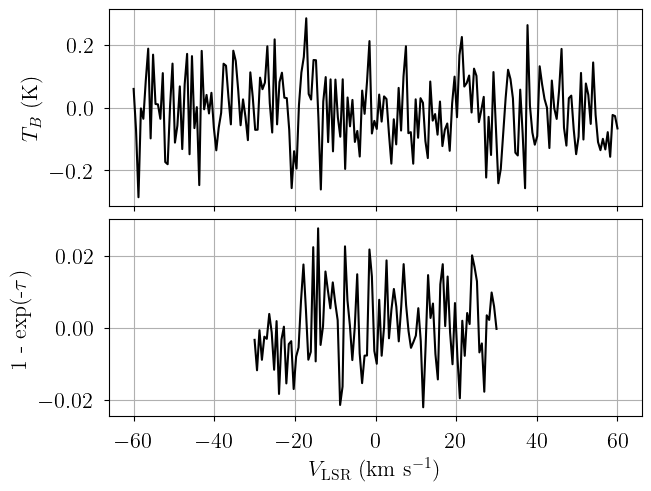

In [3]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-60.0, 60.0, 200)  # km s-1
absorption_axis = np.linspace(-30.0, 30.0, 100)  # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1  # K
rms_absorption = 0.01  # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

# Plot dummy data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(dummy_data["emission"].spectral, dummy_data["emission"].brightness, "k-")
axes[1].plot(
    dummy_data["absorption"].spectral, dummy_data["absorption"].brightness, "k-"
)
axes[1].set_xlabel(dummy_data["emission"].xlabel)
axes[0].set_ylabel(dummy_data["emission"].ylabel)
_ = axes[1].set_ylabel(dummy_data["absorption"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [6]:
from caribou_hi import EmissionAbsorptionMismatchedModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = EmissionAbsorptionMismatchedModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

In [73]:
# Evaluate likelihood for given model parameters
"""
sim_params = {
    "log10_NHI": np.array([21.0, 19.5, 21.0]),
    "log10_depth": np.array([1.5, 0.5, 1.5]),
    "log10_pressure": np.array([3.5, 3.5, 3.5]),
    "velocity": np.array([5.0, 0.0, -5.0]),
    "log10_n_alpha": -6.5,
    "log10_larson_linewidth": 0.25,
    "larson_power": 0.33,
}

sim_params_emission = sim_params.copy()
sim_params_emission["filling_factor"] = np.array([0.5, 1.0, 0.5])
sim_params_emission["baseline_emission_norm"] = np.array([-1.0, 2.0, 5.0])

sim_params_absorption = sim_params.copy()
sim_params_absorption["absorption_weight"] = np.array([1.0, 1.0, 0.5])
sim_params_absorption["baseline_absorption_norm"] = np.array([2.0, -2.0, 2.0])
"""

sim_params = {
    "log10_NHI": np.array([21.0, 20.25, 20.5]),
    "log10_depth": np.array([2.5, 1.25, 0.5]),
    "log10_pressure": np.array([3.8, 3.25, 3.5]),
    "velocity": np.array([-5.0, 0.0, 5.0]),
    "log10_n_alpha": -6.5,
    "log10_larson_linewidth": 0.25,
    "larson_power": 0.33,
}

print("log10 nHI: ", model.model["log10_nHI"].eval({k: sim_params[k] for k in ('log10_NHI', 'log10_depth')}))
print("log10 tkin: ", model.model["log10_tkin"].eval({k: sim_params[k] for k in ('log10_NHI', 'log10_depth', 'log10_pressure')}))
print("tspin: ", model.model["tspin"].eval({k: sim_params[k] for k in ('log10_NHI', 'log10_depth', 'log10_pressure')}))

sim_params_emission = sim_params.copy()
sim_params_emission["filling_factor"] = np.array([1.0, 0.5, 0.5])
sim_params_emission["baseline_emission_norm"] = np.array([-1.0, 2.0, 5.0])

sim_params_absorption = sim_params.copy()
sim_params_absorption["absorption_weight"] = np.array([1.0, 1.0, 0.0])
sim_params_absorption["baseline_absorption_norm"] = np.array([2.0, -2.0, 2.0])

emission = model.model["emission"].eval(sim_params_emission)
absorption = model.model["absorption"].eval(sim_params_absorption)

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

log10 nHI:  [0.01065 0.51065 1.51065]
log10 tkin:  [3.74795731 2.69795731 1.94795731]
tspin:  [4002.13062729  489.49388862   88.62930948]


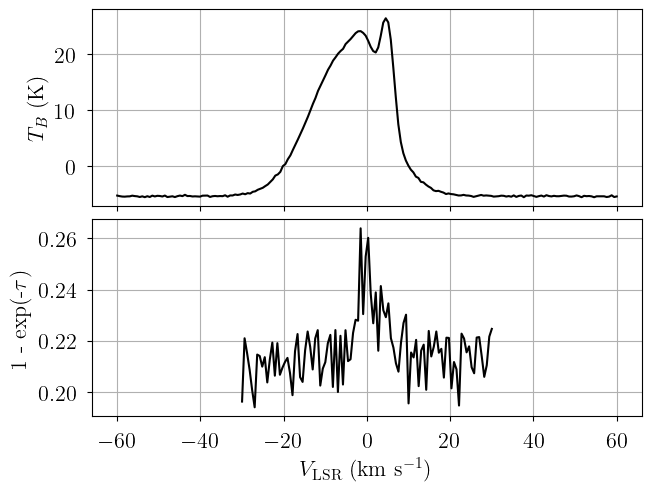

In [74]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
_ = axes[1].set_ylabel(data["absorption"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [76]:
# Initialize and define the model
model = EmissionAbsorptionMismatchedModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    # prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_NHI=[20.0, 2.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

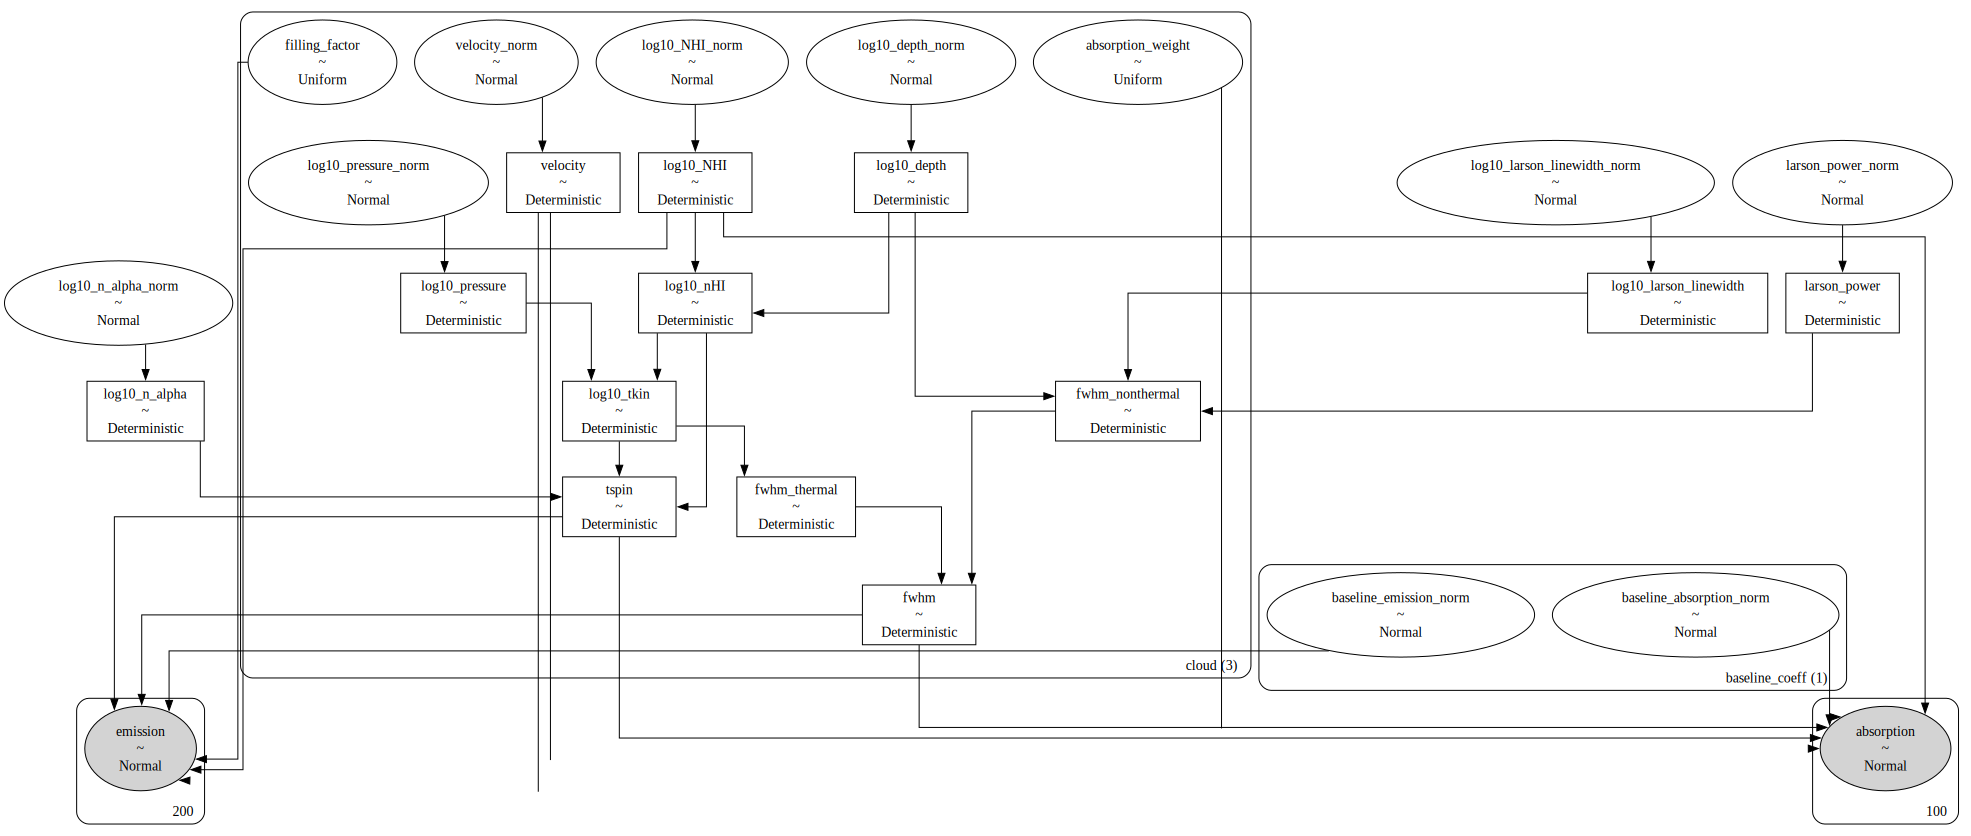

In [77]:
# Plot model graph
model.graph().render("emission_absorption_mismatched_model", format="png")
model.graph()

In [78]:
# model string representation
print(model.model.str_repr())

     baseline_emission_norm ~ Normal(0, 1)
   baseline_absorption_norm ~ Normal(0, 1)
             log10_NHI_norm ~ Normal(0, 1)
           log10_depth_norm ~ Normal(0, 1)
        log10_pressure_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
         log10_n_alpha_norm ~ Normal(0, 1)
log10_larson_linewidth_norm ~ Normal(0, 1)
          larson_power_norm ~ Normal(0, 1)
             filling_factor ~ Uniform(0, 1)
          absorption_weight ~ Uniform(0, 1)
                  log10_NHI ~ Deterministic(f(log10_NHI_norm))
                log10_depth ~ Deterministic(f(log10_depth_norm))
             log10_pressure ~ Deterministic(f(log10_pressure_norm))
                   velocity ~ Deterministic(f(velocity_norm))
              log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_larson_linewidth ~ Deterministic(f(log10_larson_linewidth_norm))
               larson_power ~ Deterministic(f(larson_power_norm))
                  log10_nHI ~ Deterministic(f(log10_depth_

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption, absorption_weight, baseline_absorption_norm, baseline_emission_norm, emission, filling_factor, larson_power_norm, log10_NHI_norm, log10_depth_norm, log10_larson_linewidth_norm, log10_n_alpha_norm, log10_pressure_norm, velocity_norm]


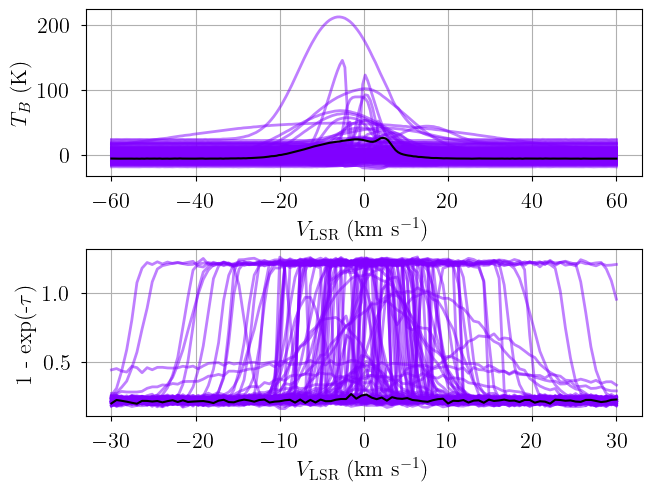

In [79]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

Or we can inspect the prior distributions of the derived quantities to check that they are physically reasonable.

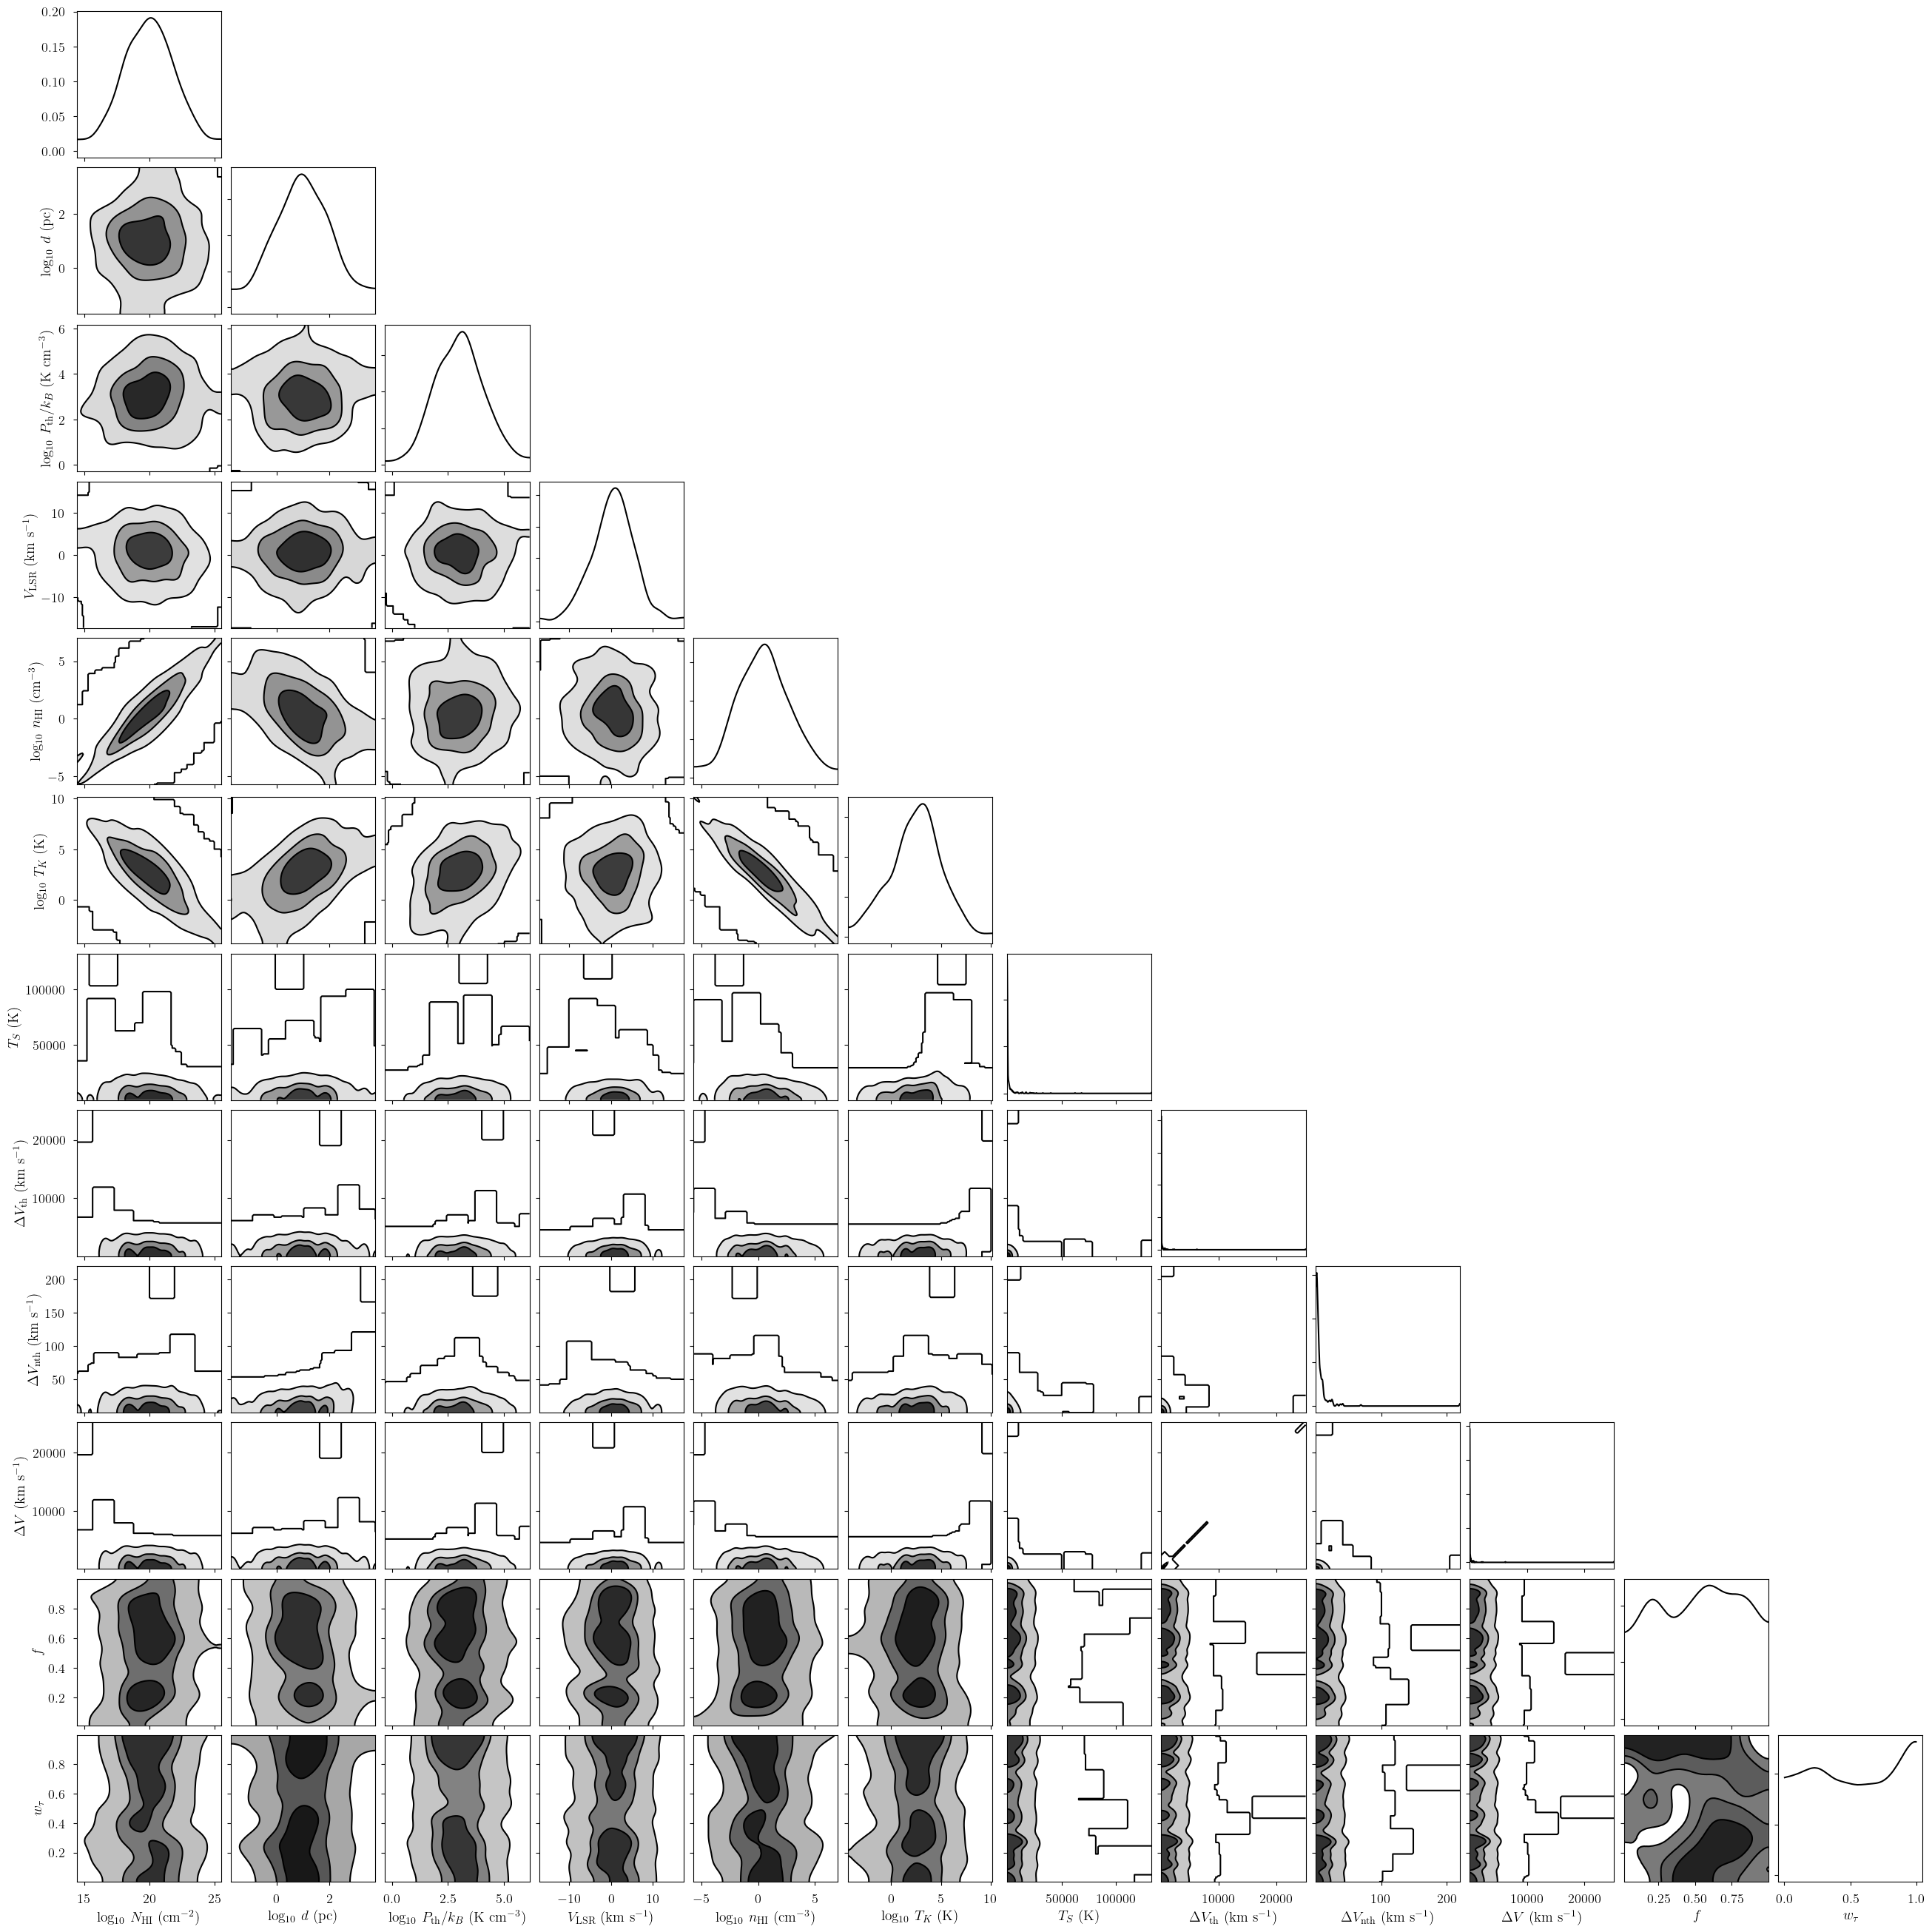

In [80]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    prior.prior,  # samples
    model.cloud_deterministics + ["filling_factor", "absorption_weight"],  # var_names to plot
    labeller=model.labeller,  # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [81]:
start = time.time()
model.fit(
    n=100_000,  # maximum number of VI iterations
    draws=1_000,  # number of posterior samples
    rel_tolerance=0.01,  # VI relative convergence threshold
    abs_tolerance=0.05,  # VI absolute convergence threshold
    learning_rate=1e-2,  # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 10700
Interrupted at 10,699 [10%]: Average Loss = 1.555e+05


Output()

Runtime: 0.57 minutes


In [82]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd   hdi_3%  hdi_97%  mcse_mean  \
absorption_weight[0]           0.164  0.023    0.122    0.203      0.001   
absorption_weight[1]           0.019  0.009    0.005    0.036      0.000   
absorption_weight[2]           0.008  0.009    0.000    0.022      0.000   
baseline_absorption_norm[0]   -0.381  0.085   -0.525   -0.205      0.003   
baseline_emission_norm[0]     -0.565  0.001   -0.566   -0.563      0.000   
filling_factor[0]              0.754  0.003    0.749    0.759      0.000   
filling_factor[1]              0.818  0.002    0.815    0.822      0.000   
filling_factor[2]              0.729  0.001    0.728    0.731      0.000   
fwhm[0]                        6.530  0.034    6.469    6.590      0.001   
fwhm[1]                        3.289  0.014    3.264    3.314      0.000   
fwhm[2]                       19.520  0.046   19.436   19.607      0.001   
fwhm_nonthermal[0]             6.227  0.031    6.172    6.284      0.001   
fwhm_nonthermal[1]             2.784  0.008    2.769    2.799      0.000   
fwhm_nonthermal[2]            19.314  0.046   19.222   19.392      0.001   
fwhm_thermal[0]                1.964  0.034    1.897    2.025      0.001   
fwhm_thermal[1]                1.752  0.020    1.716    1.788      0.001   
fwhm_thermal[2]                2.830  0.012    2.810    2.852      0.000   
larson_power                   0.509  0.000    0.509    0.510      0.000   
larson_power_norm              1.092  0.003    1.087    1.097      0.000   
log10_NHI[0]                  20.301  0.014   20.274   20.326      0.000   
log10_NHI[1]                  20.424  0.009   20.407   20.442      0.000   
log10_NHI[2]                  21.183  0.001   21.182   21.184      0.000   
log10_NHI_norm[0]              0.151  0.007    0.137    0.163      0.000   
log10_NHI_norm[1]              0.212  0.005    0.204    0.221      0.000   
log10_NHI_norm[2]              0.592  0.000    0.591    0.592      0.000   
log10_depth[0]                 0.976  0.004    0.969    0.984      0.000   
log10_depth[1]                 0.289  0.002    0.285    0.293      0.000   
log10_depth[2]                 1.942  0.001    1.939    1.944      0.000   
log10_depth_norm[0]           -0.024  0.004   -0.031   -0.016      0.000   
log10_depth_norm[1]           -0.711  0.002   -0.715   -0.707      0.000   
log10_depth_norm[2]            0.942  0.001    0.939    0.944      0.000   
log10_larson_linewidth         0.297  0.001    0.296    0.298      0.000   
log10_larson_linewidth_norm    0.972  0.005    0.962    0.982      0.000   
log10_nHI[0]                   0.836  0.015    0.808    0.862      0.000   
log10_nHI[1]                   1.645  0.010    1.628    1.663      0.000   
log10_nHI[2]                   0.752  0.001    0.749    0.755      0.000   
log10_n_alpha                 -5.832  0.947   -7.744   -4.209      0.030   
log10_n_alpha_norm             0.168  0.947   -1.744    1.791      0.030   
log10_pressure[0]              2.803  0.003    2.797    2.810      0.000   
log10_pressure[1]              3.514  0.002    3.510    3.518      0.000   
log10_pressure[2]              3.037  0.003    3.030    3.042      0.000   
log10_pressure_norm[0]        -0.197  0.003   -0.203   -0.190      0.000   
log10_pressure_norm[1]         0.514  0.002    0.510    0.518      0.000   
log10_pressure_norm[2]         0.037  0.003    0.030    0.042      0.000   
log10_tkin[0]                  1.926  0.015    1.900    1.956      0.001   
log10_tkin[1]                  1.827  0.010    1.809    1.844      0.000   
log10_tkin[2]                  2.243  0.004    2.237    2.250      0.000   
tspin[0]                      84.258  2.915   79.074   90.109      0.100   
tspin[1]                      67.105  1.499   64.316   69.852      0.045   
tspin[2]                     174.577  1.478  172.114  177.571      0.049   
velocity[0]                   -0.429  0.026   -0.477   -0.382      0.001   
velocity[1]                    4.848  0.007    4.835    4.860      0.000   
velo

Sampling: [absorption, emission]


Output()

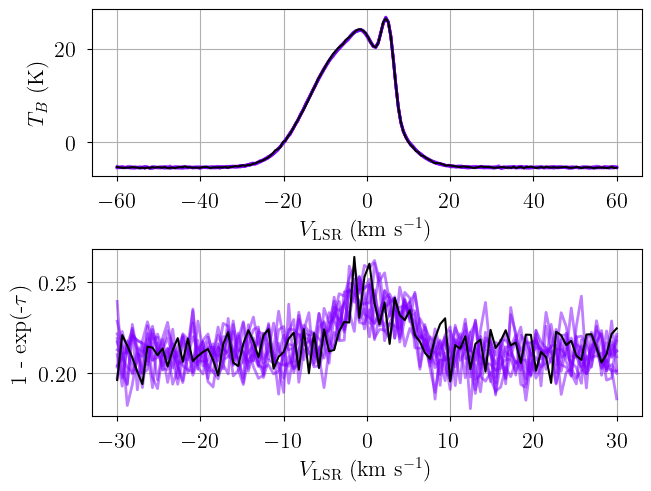

In [83]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

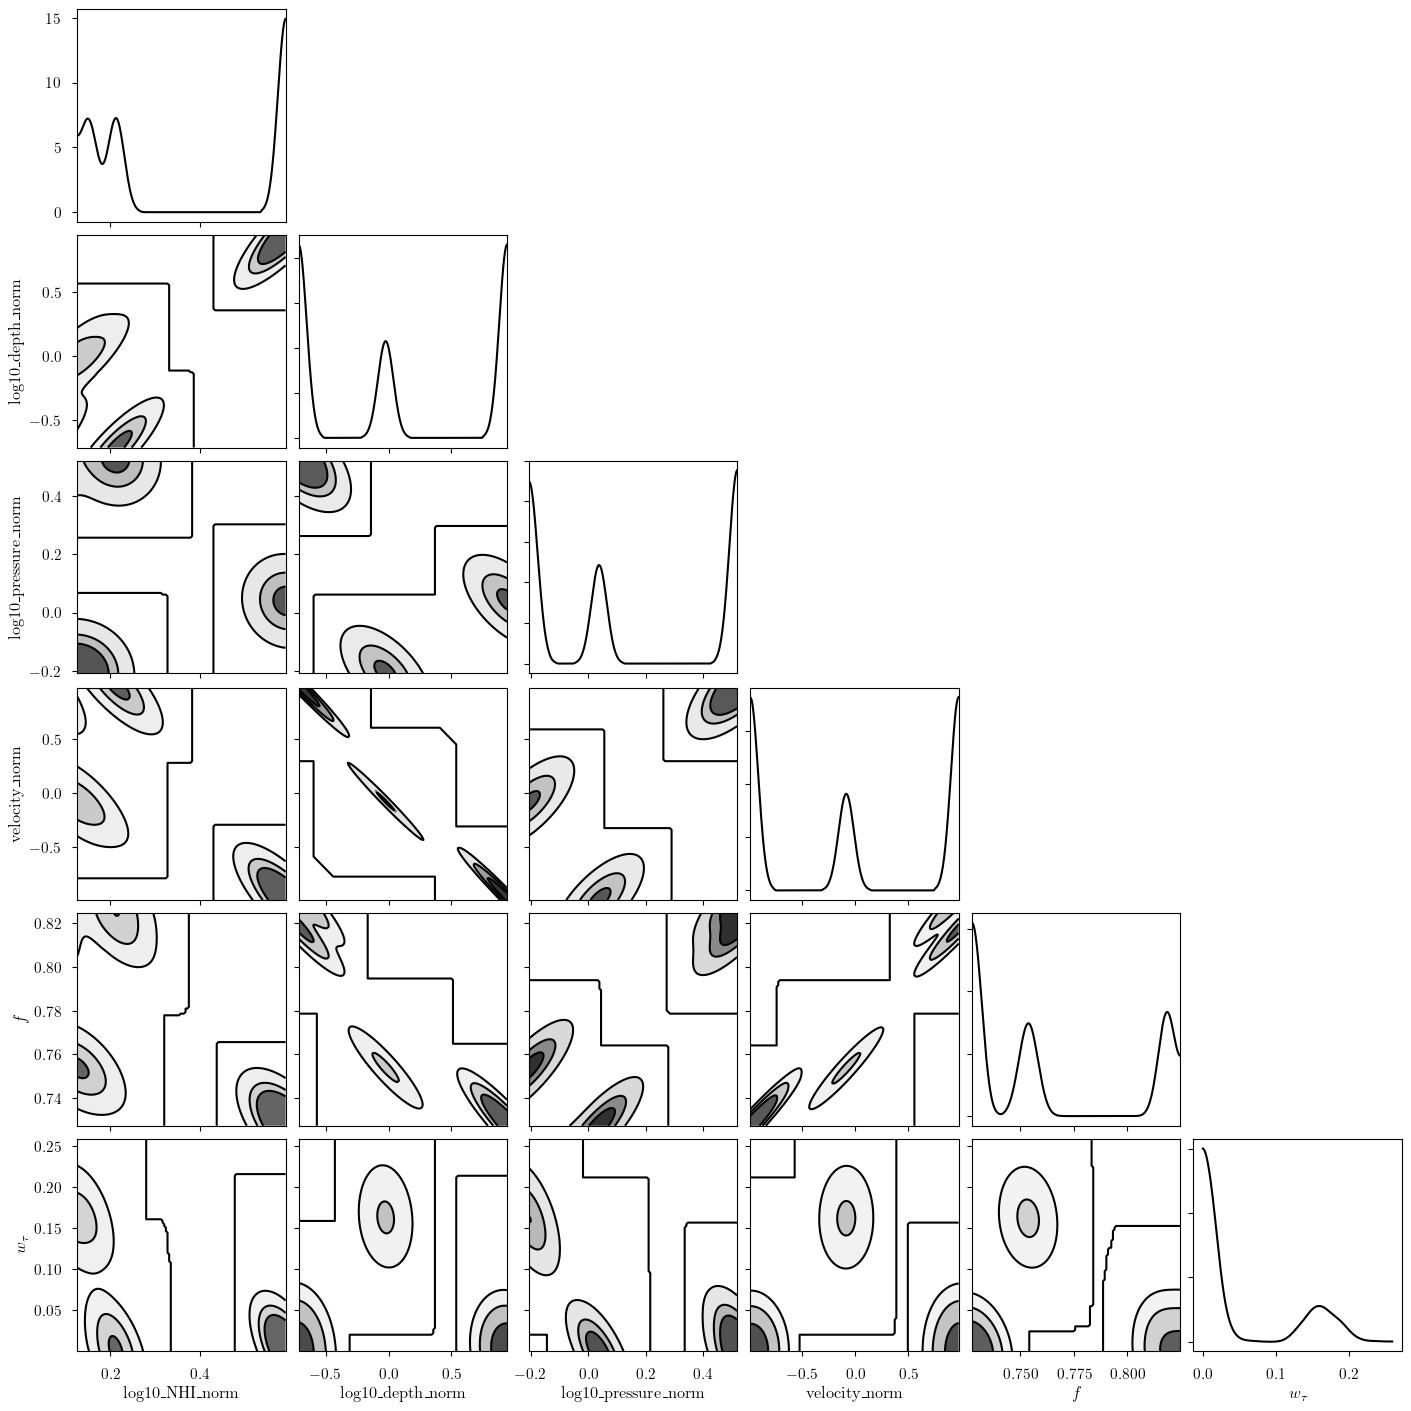

In [84]:
_ = plot_pair(
    model.trace.posterior,  # samples
    model.cloud_freeRVs,  # var_names to plot
    labeller=model.labeller,  # label manager
)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [85]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=2000,  # tuning samples
    draws=1000,  # posterior samples
    chains=6,  # number of independent chains
    cores=6,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.01,
        "abs_tolerance": 0.05,
        "learning_rate": 1e-2,
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 10700
Interrupted at 10,699 [10%]: Average Loss = 1.555e+05
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, filling_factor, absorption_weight]


Output()

Sampling 6 chains for 2_000 tune and 1_000 draw iterations (12_000 + 6_000 draws total) took 2334 seconds.


Adding log-likelihood to trace


Output()

There were 795 divergences in converged chains.
Runtime: 40.07 minutes


In [86]:
model.solve()

GMM converged to unique solution
4 of 6 chains appear converged.


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [87]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean        sd    hdi_3%   hdi_97%  \
absorption_weight[0]            0.643     0.237     0.243     0.999   
absorption_weight[1]            0.026     0.013     0.003     0.049   
absorption_weight[2]            0.341     0.259     0.001     0.830   
baseline_absorption_norm[0]    -0.374     0.097    -0.552    -0.196   
baseline_emission_norm[0]      -0.566     0.001    -0.567    -0.564   
filling_factor[0]               0.511     0.226     0.156     0.925   
filling_factor[1]               0.672     0.194     0.356     0.988   
filling_factor[2]               0.775     0.162     0.499     1.000   
fwhm[0]                         6.493     0.158     6.207     6.806   
fwhm[1]                         3.380     0.051     3.286     3.476   
fwhm[2]                        19.936     0.035    19.875    20.004   
fwhm_nonthermal[0]              4.616     1.117     2.401     6.104   
fwhm_nonthermal[1]              2.499     0.378     1.777     2.934   
fwhm_nonthermal[2]              9.290     4.267     2.454    16.918   
fwhm_thermal[0]                 4.290     1.110     2.500     6.361   
fwhm_thermal[1]                 2.212     0.383     1.618     2.912   
fwhm_thermal[2]                16.852     2.991    10.823    19.859   
larson_power                    0.355     0.088     0.189     0.520   
larson_power_norm              -0.449     0.875    -2.107     1.205   
log10_NHI[0]                   20.349     0.224    19.990    20.754   
log10_NHI[1]                   20.476     0.145    20.267    20.766   
log10_NHI[2]                   21.123     0.105    20.998    21.303   
log10_NHI_norm[0]               0.175     0.112    -0.005     0.377   
log10_NHI_norm[1]               0.238     0.073     0.134     0.383   
log10_NHI_norm[2]               0.561     0.053     0.499     0.651   
log10_depth[0]                  1.340     0.435     0.565     2.167   
log10_depth[1]                  0.602     0.337     0.014     1.287   
log10_depth[2]                  2.101     0.576     1.066     3.235   
log10_depth_norm[0]             0.340     0.435    -0.435     1.167   
log10_depth_norm[1]            -0.398     0.337    -0.986     0.287   
log10_depth_norm[2]             1.101     0.576     0.066     2.235   
log10_larson_linewidth          0.188     0.096     0.010     0.376   
log10_larson_linewidth_norm    -0.125     0.960    -1.896     1.757   
log10_nHI[0]                    0.520     0.536    -0.491     1.524   
log10_nHI[1]                    1.384     0.410     0.583     2.124   
log10_nHI[2]                    0.532     0.587    -0.652     1.557   
log10_n_alpha                  -5.954     0.981    -7.748    -4.117   
log10_n_alpha_norm              0.046     0.981    -1.748     1.883   
log10_pressure[0]               3.134     0.699     1.887     4.467   
log10_pressure[1]               3.442     0.512     2.525     4.433   
log10_pressure[2]               4.348     0.682     3.078     5.602   
log10_pressure_norm[0]          0.134     0.699    -1.113     1.467   
log10_pressure_norm[1]          0.442     0.512    -0.475     1.433   
log10_pressure_norm[2]          1.348     0.682     0.078     2.602   
log10_tkin[0]                   2.573     0.242     2.155     2.963   
log10_tkin[1]                   2.017     0.146     1.783     2.286   
log10_tkin[2]                   3.775     0.188     3.412     3.937   
tspin[0]                      424.895   208.146    98.960   813.581   
tspin[1]                      110.071    39.099    57.160   185.126   
tspin[2]                     5730.522  1914.326  2211.485  8516.462   
velocity[0]                    -0.212     0.079    -0.369    -0.071   
velocity[1]                     4.894     0.021     4.854     4.931   
velocity[2]                    -4.985     0.020    -5.021    -4.948   
velocity_norm[0]               -0.042     0.016    -0.074    -0.014   
velocity_norm[1]                0.979     0.004     0.971     0.986   
velocity_norm[2]               -0.997     0.004    -1.004

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [absorption, emission]


Output()

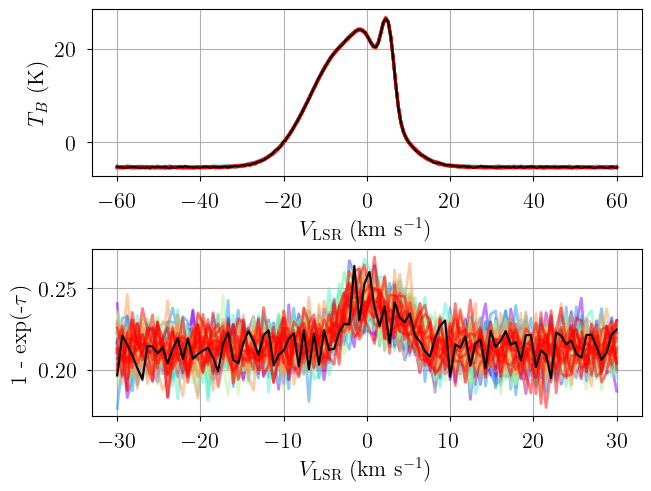

In [88]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

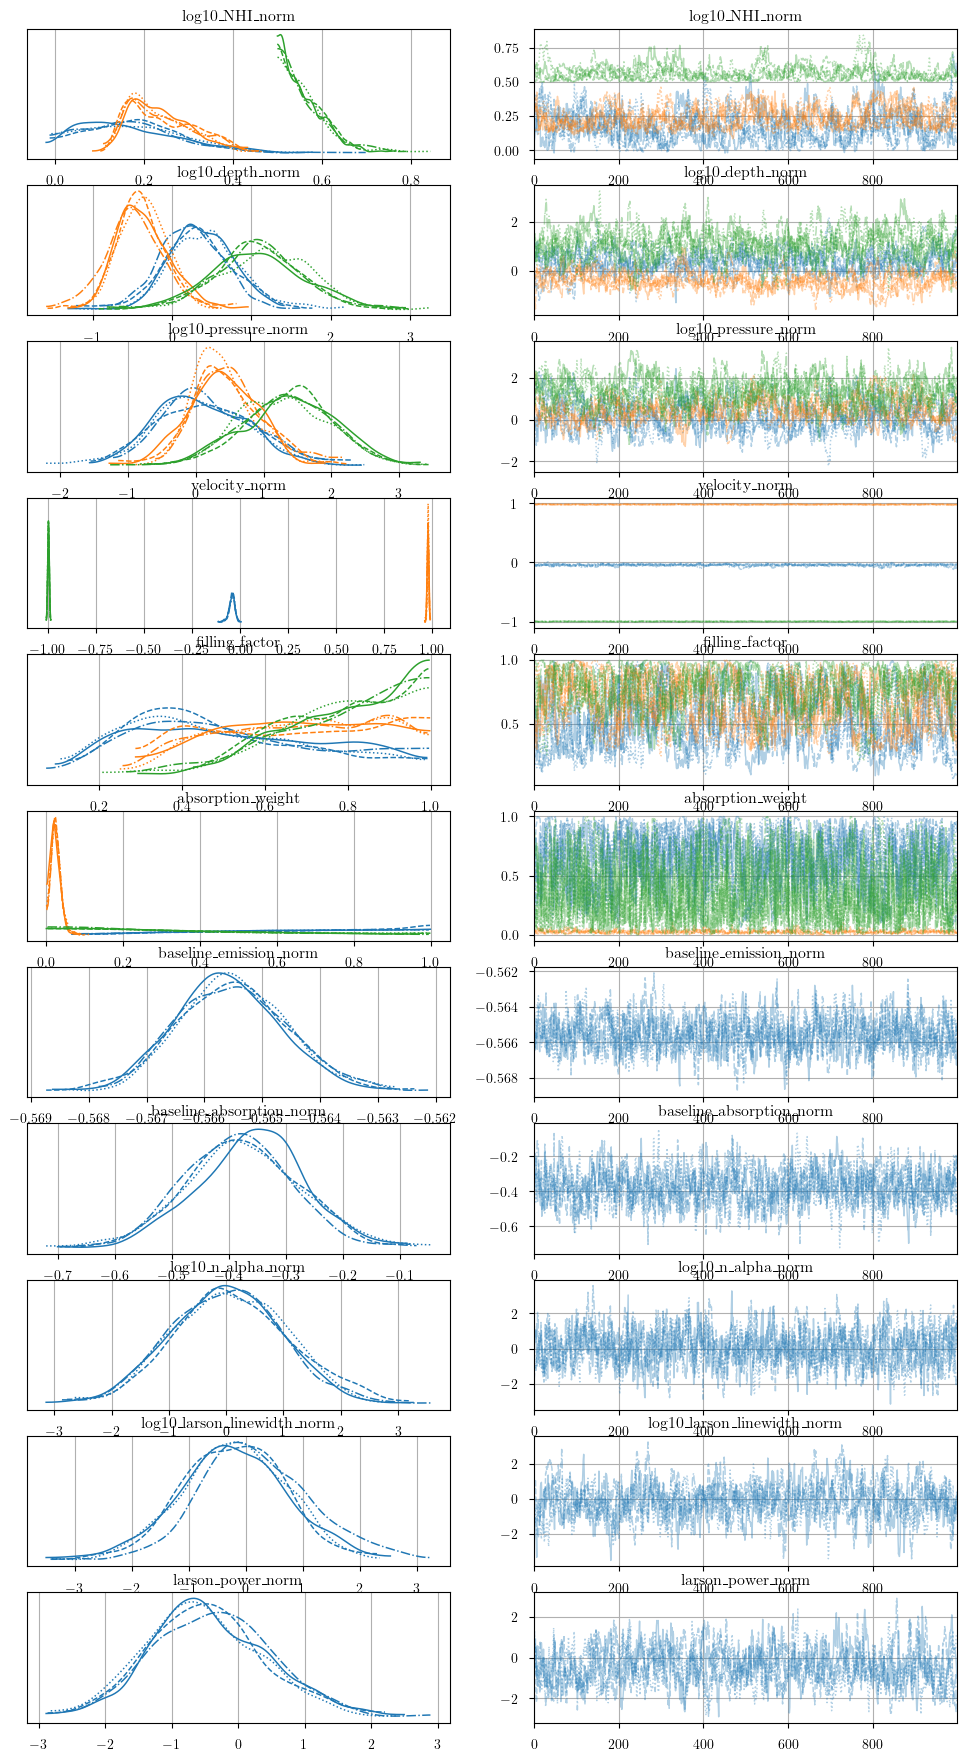

In [89]:
from bayes_spec.plots import plot_traces

_ = plot_traces(
    model.trace.solution_0,
    model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs,
)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

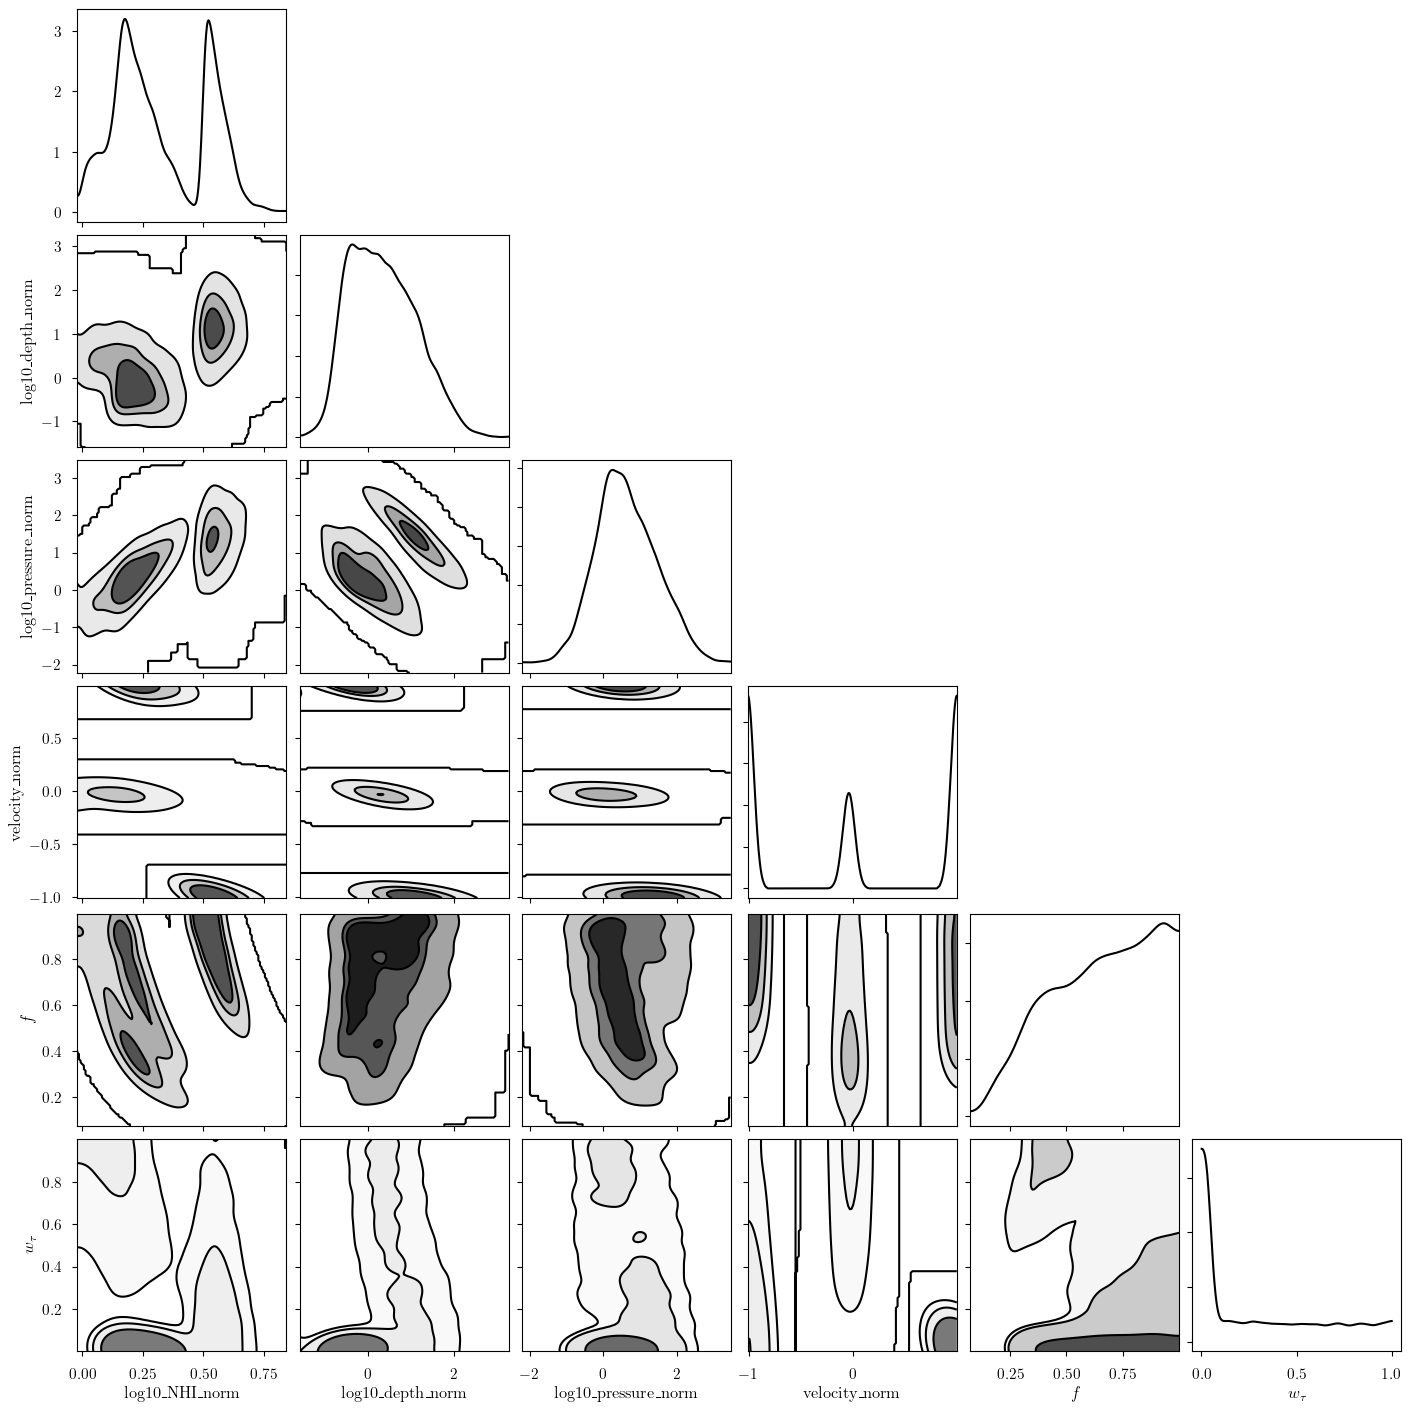

In [90]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0,  # samples
    model.cloud_freeRVs,  # var_names to plot
    labeller=model.labeller,  # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud. Also notice the tight correlation between column density and excitation temperature: optical depth spectra alone struggle to break this degeneracy!

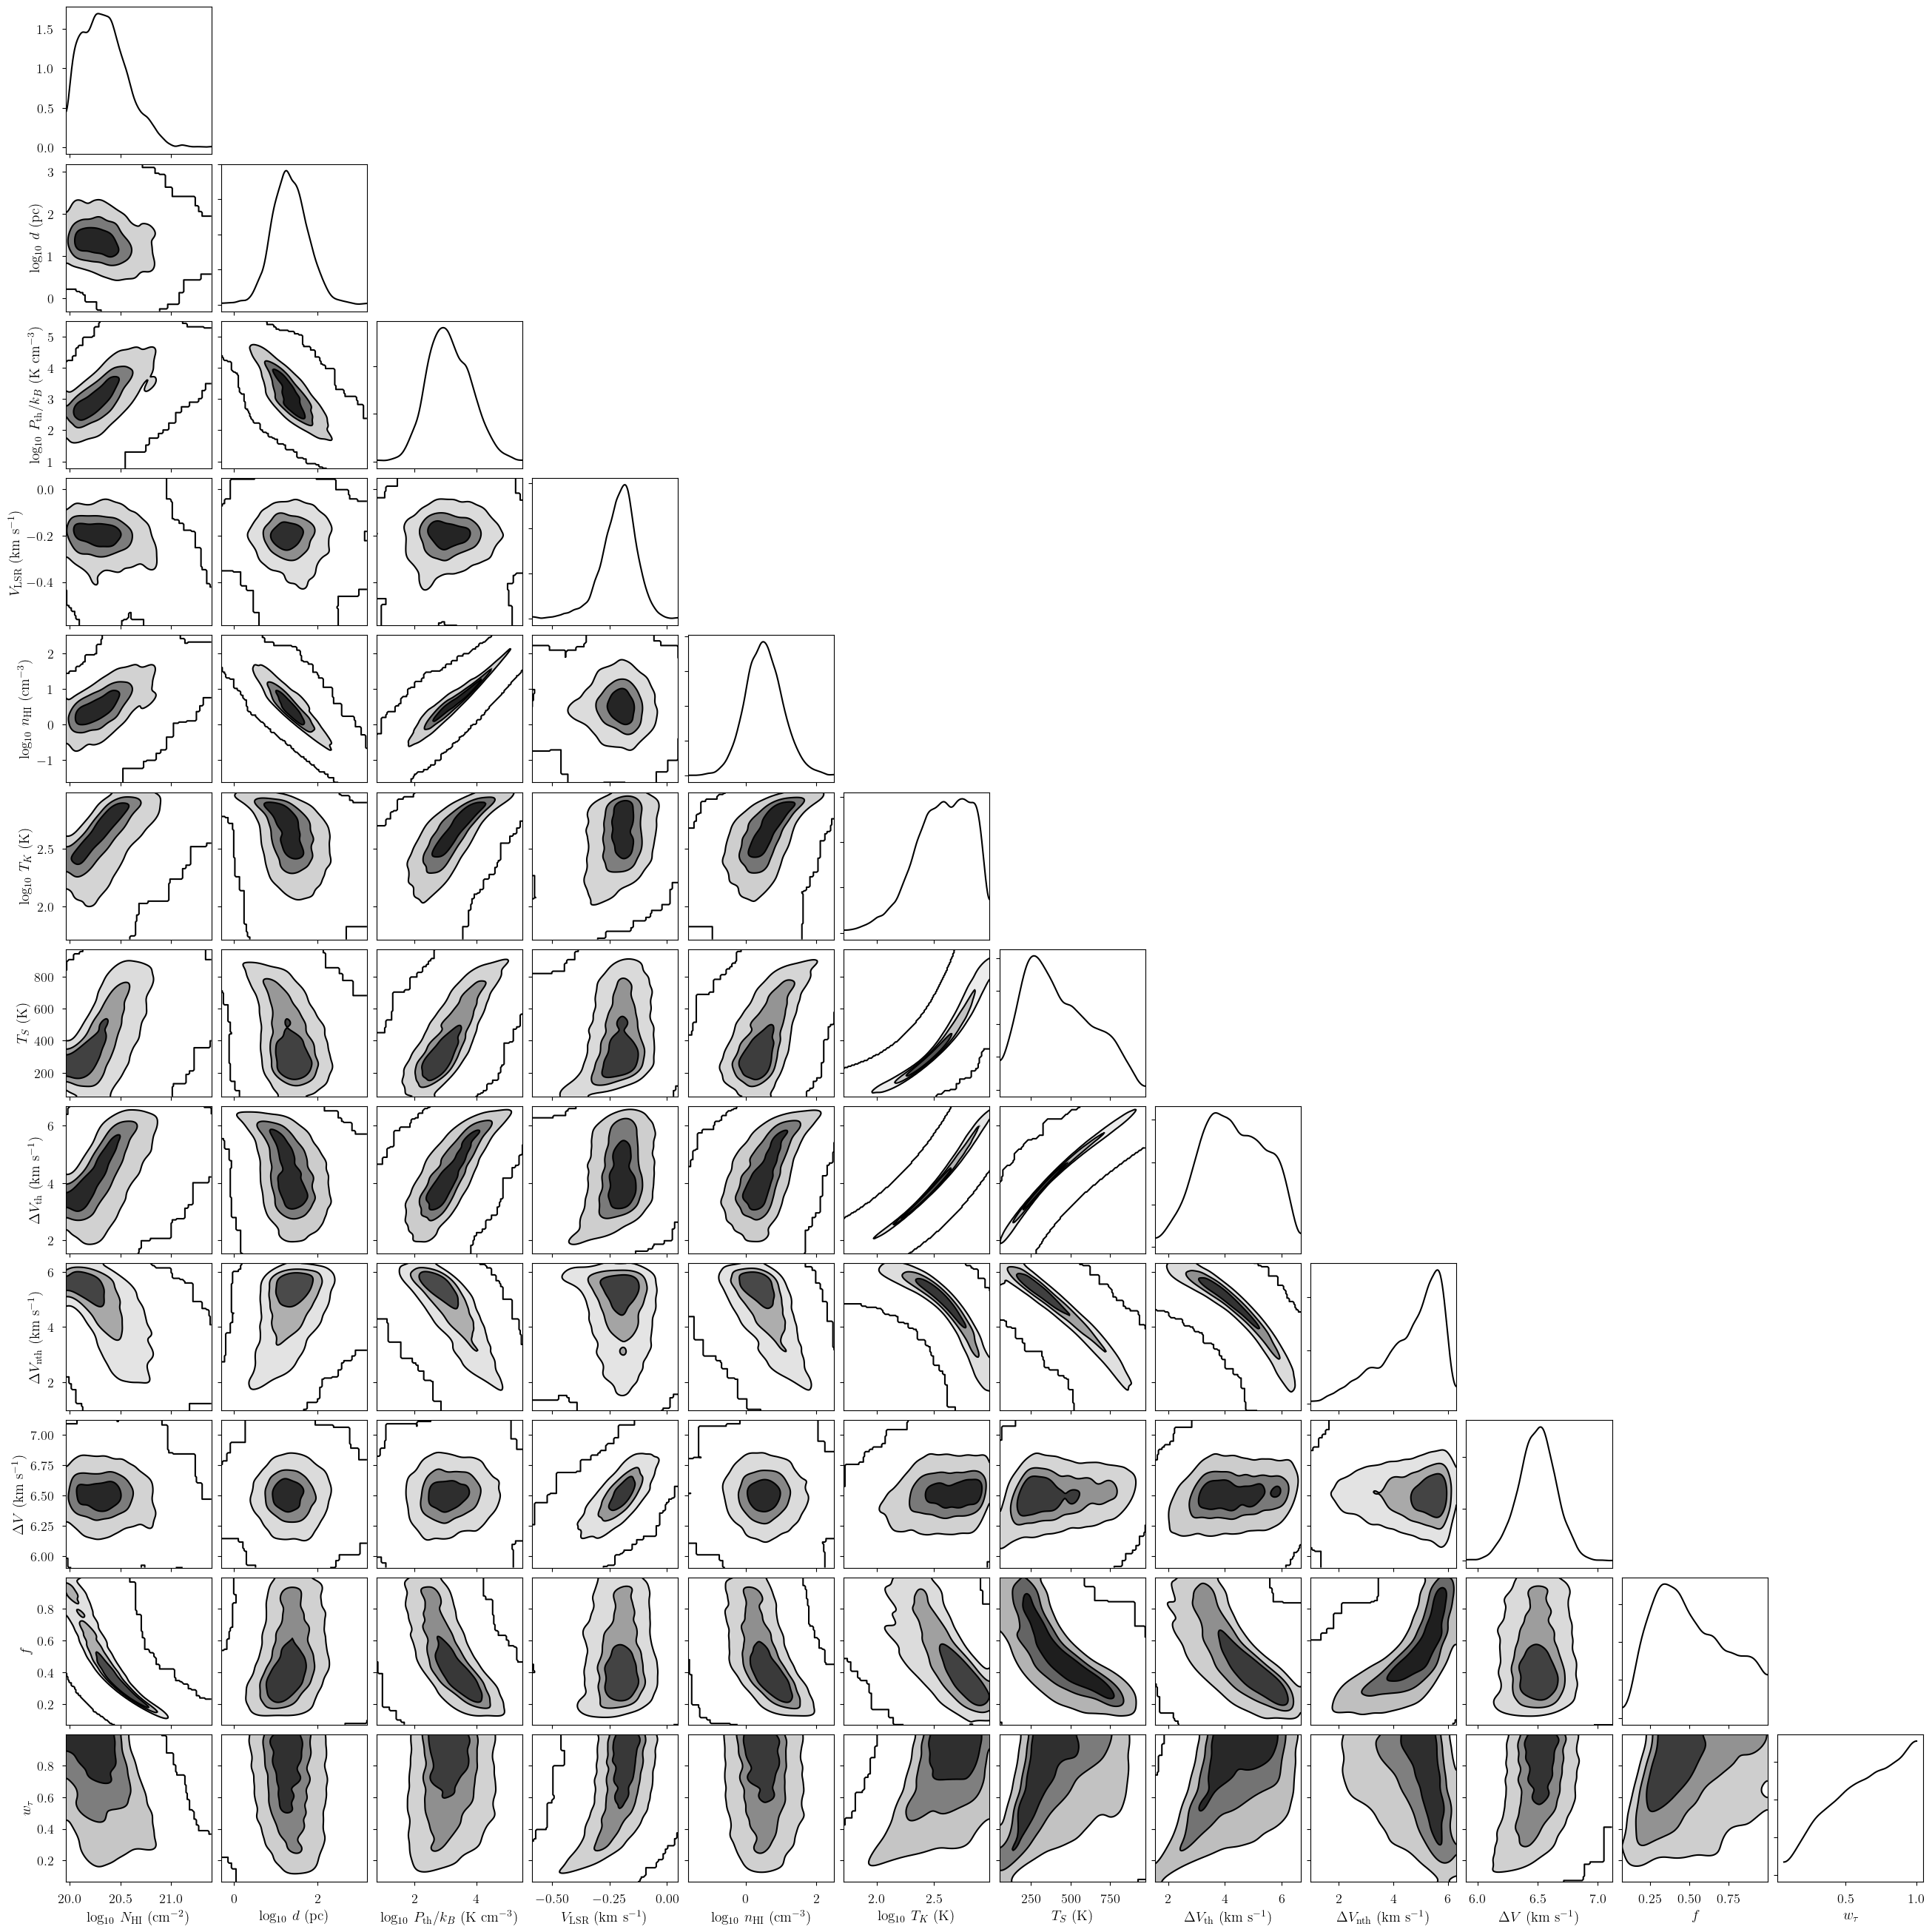

In [91]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0),  # samples
    model.cloud_deterministics + ["filling_factor", "absorption_weight"],  # var_names to plot
    labeller=model.labeller,  # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [92]:
point_stats = az.summary(model.trace.solution_0, kind="stats", hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -902.6220616964264


mean        sd   hdi_16%   hdi_84%
absorption_weight[0]            0.643     0.237     0.523     0.999
absorption_weight[1]            0.026     0.013     0.011     0.035
absorption_weight[2]            0.341     0.259     0.003     0.433
baseline_absorption_norm[0]    -0.374     0.097    -0.482    -0.291
baseline_emission_norm[0]      -0.566     0.001    -0.567    -0.565
filling_factor[0]               0.511     0.226     0.189     0.659
filling_factor[1]               0.672     0.194     0.535     0.968
filling_factor[2]               0.775     0.162     0.705     0.999
fwhm[0]                         6.493     0.158     6.358     6.661
fwhm[1]                         3.380     0.051     3.330     3.429
fwhm[2]                        19.936     0.035    19.904    19.972
fwhm_nonthermal[0]              4.616     1.117     4.147     6.006
fwhm_nonthermal[1]              2.499     0.378     2.411     2.916
fwhm_nonthermal[2]              9.290     4.267     3.065    11.836
fwhm_thermal[0]                 4.290     1.110     3.032     5.452
fwhm_thermal[1]                 2.212     0.383     1.687     2.418
fwhm_thermal[2]                16.852     2.991    16.358    19.842
larson_power                    0.355     0.088     0.255     0.428
larson_power_norm              -0.449     0.875    -1.450     0.276
log10_NHI[0]                   20.349     0.224    20.060    20.497
log10_NHI[1]                   20.476     0.145    20.277    20.555
log10_NHI[2]                   21.123     0.105    20.999    21.153
log10_NHI_norm[0]               0.175     0.112     0.030     0.248
log10_NHI_norm[1]               0.238     0.073     0.139     0.277
log10_NHI_norm[2]               0.561     0.053     0.500     0.576
log10_depth[0]                  1.340     0.435     0.874     1.690
log10_depth[1]                  0.602     0.337     0.280     0.914
log10_depth[2]                  2.101     0.576     1.570     2.687
log10_depth_norm[0]             0.340     0.435    -0.126     0.690
log10_depth_norm[1]            -0.398     0.337    -0.720    -0.086
log10_depth_norm[2]             1.101     0.576     0.570     1.687
log10_larson_linewidth          0.188     0.096     0.105     0.289
log10_larson_linewidth_norm    -0.125     0.960    -0.952     0.894
log10_nHI[0]                    0.520     0.536     0.019     1.036
log10_nHI[1]                    1.384     0.410     0.978     1.745
log10_nHI[2]                    0.532     0.587    -0.041     1.111
log10_n_alpha                  -5.954     0.981    -6.998    -5.039
log10_n_alpha_norm              0.046     0.981    -0.998     0.961
log10_pressure[0]               3.134     0.699     2.376     3.755
log10_pressure[1]               3.442     0.512     2.874     3.835
log10_pressure[2]               4.348     0.682     3.713     5.086
log10_pressure_norm[0]          0.134     0.699    -0.624     0.755
log10_pressure_norm[1]          0.442     0.512    -0.126     0.835
log10_pressure_norm[2]          1.348     0.682     0.713     2.086
log10_tkin[0]                   2.573     0.242     2.427     2.901
log10_tkin[1]                   2.017     0.146     1.817     2.126
log10_tkin[2]                   3.775     0.188     3.767     3.935
tspin[0]                      424.895   208.146   156.701   578.368
tspin[1]                      110.071    39.099    60.968   126.085
tspin[2]                     5730.522  1914.326  4805.045  8368.153
velocity[0]                    -0.212     0.079    -0.272    -0.134
velocity[1]                     4.894     0.021     4.876     4.915
velocity[2]                    -4.985     0.020    -5.003    -4.964
velocity_norm[0]               -0.042     0.016    -0.054    -0.027
velocity_norm[1]                0.979     0.004     0.975     0.983
velocity_norm[2]               -0.997     0.004    -1.001    -0.993